In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import os

In [3]:
# Script definitions
# ------------------

# DAXPY - data_1.csv
# Histogram_1 - data_2.csv
# Histogram_2 - data_3.csv

data_file = '../../lab2/data/data_4.csv'
images_dir = '../images/conv2d_1/'

fixed_image = './images/grayscale_by_cols.pgm'


In [4]:
# Create the output directory if it doesn't exist
if not os.path.exists(images_dir):

	os.mkdir(images_dir)

else :

	os.system("rm -r " + images_dir)
	os.mkdir(images_dir)

In [5]:
# Load the data into a pandas DataFrame
data = pd.read_csv(data_file, sep=',', header=None)

# Add column names to the DataFrame
# DAXPY - printf("PAE,%d,%d,%d,%f,%f,%f,%f,%f,%f,%ld,%f,PAE\n", threadsPerBlock, blocksPerGrid, maxBlocksPerSM, occupancy, overhead, alloc_time, init_time, daxpy_time, total_time, n, alpha);
# Histogram - printf("\nPAE,%s,%d,%d,%d,%f,%f,%f,%f,%f,%f,%f,%f,%ld,PAE\n", imagePath, threadsPerBlock, blocksPerGrid, maxBlocksPerSM, occupancy, overhead, alloc_time, init_time, conv_time, hd_time, dh_time, total_time, imageSize);

data.columns = ['imagePath', 'threadsPerBlock', 'totalBlocksPerGrid', 'maxBlocksPerSM', 'occupancy', 'overhead', 'alloc_time', 'init_time', 'conv_time', 'hd_time', 'dh_time', 'total_time', 'imageSize']

# Print total number of rows and columns in the DataFrame
print("Total rows: {0}".format(len(data)))

Total rows: 330


In [6]:
data = data[data['overhead'] < 0.1]

print("Total rows: {0}".format(len(data)))

Total rows: 330


In [7]:
data_filtered = data[data['imagePath'] == fixed_image]

df_filtered = data_filtered[['threadsPerBlock', 'occupancy', 'conv_time']]

df_max_occupancy = df_filtered[df_filtered['occupancy'] == 1.0]

grouped = df_max_occupancy.groupby('threadsPerBlock')['conv_time'].mean()

min_conv_time = grouped.idxmin()

print("Threads per block to get min daxpy time with full occupancy: {0}".format(min_conv_time))

Threads per block to get min daxpy time with full occupancy: 256


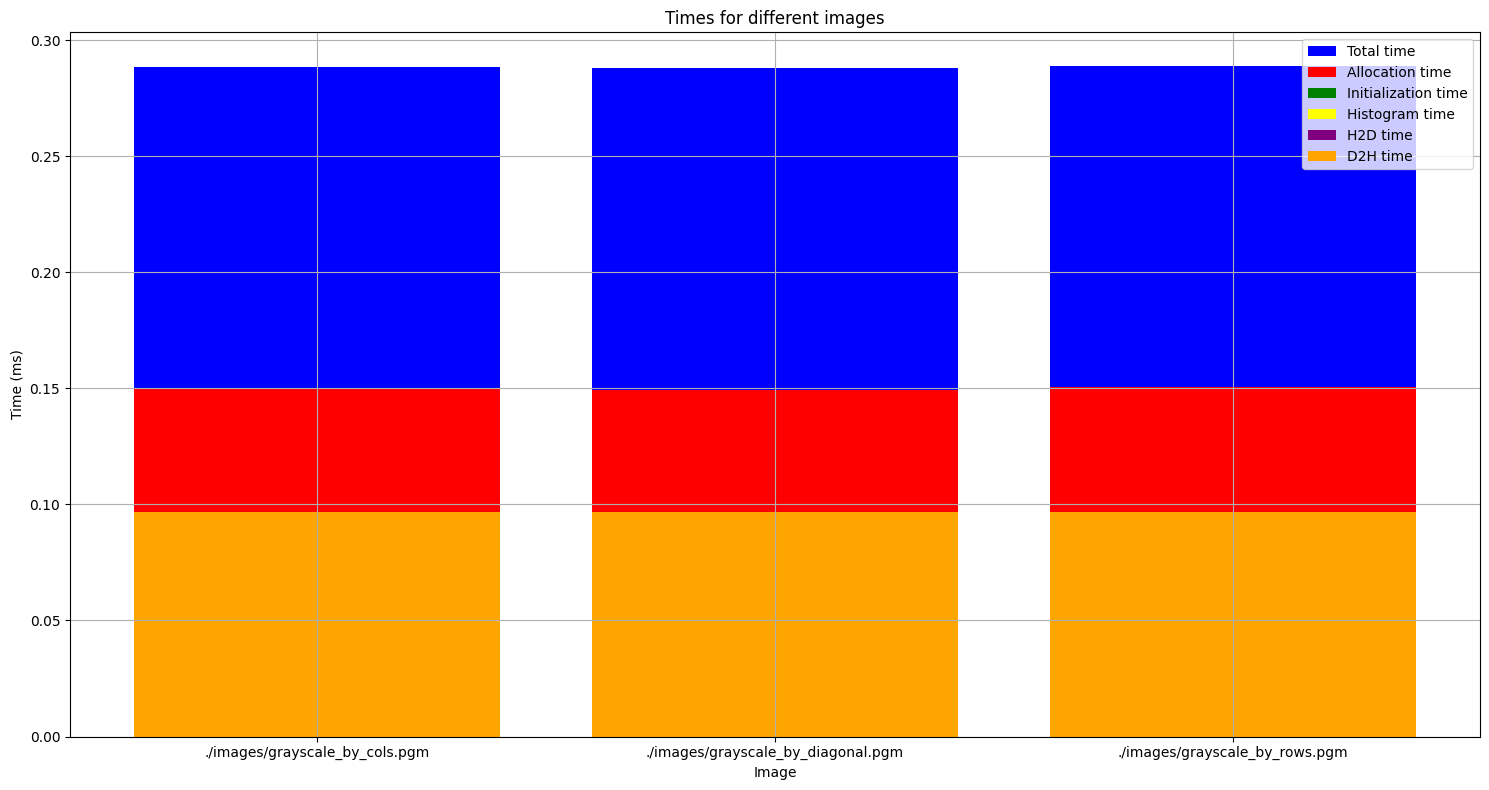

In [8]:
new_data = data[data['threadsPerBlock'] == 256]

mean_alloc_time = new_data.groupby('imagePath')['alloc_time'].mean()
mean_init_time = new_data.groupby('imagePath')['init_time'].mean()
mean_conv_time = new_data.groupby('imagePath')['conv_time'].mean()
mean_hd_time = new_data.groupby('imagePath')['hd_time'].mean()
mean_dh_time = new_data.groupby('imagePath')['dh_time'].mean()
mean_total_time = new_data.groupby('imagePath')['total_time'].mean()

plt.figure(figsize=(15, 8))

plt.bar(mean_total_time.index, mean_total_time, color='blue', label='Total time')
plt.bar(mean_alloc_time.index, mean_alloc_time, color='red', label='Allocation time')
plt.bar(mean_init_time.index, mean_init_time, color='green', label='Initialization time')
plt.bar(mean_conv_time.index, mean_conv_time, color='yellow', label='Histogram time')
plt.bar(mean_hd_time.index, mean_hd_time, color='purple', label='H2D time')
plt.bar(mean_dh_time.index, mean_dh_time, color='orange', label='D2H time')

plt.xlabel('Image')
plt.ylabel('Time (ms)')

plt.title('Times for different images')

plt.legend()
plt.grid()
plt.tight_layout()

plt.savefig(images_dir + '/execution_times.png')

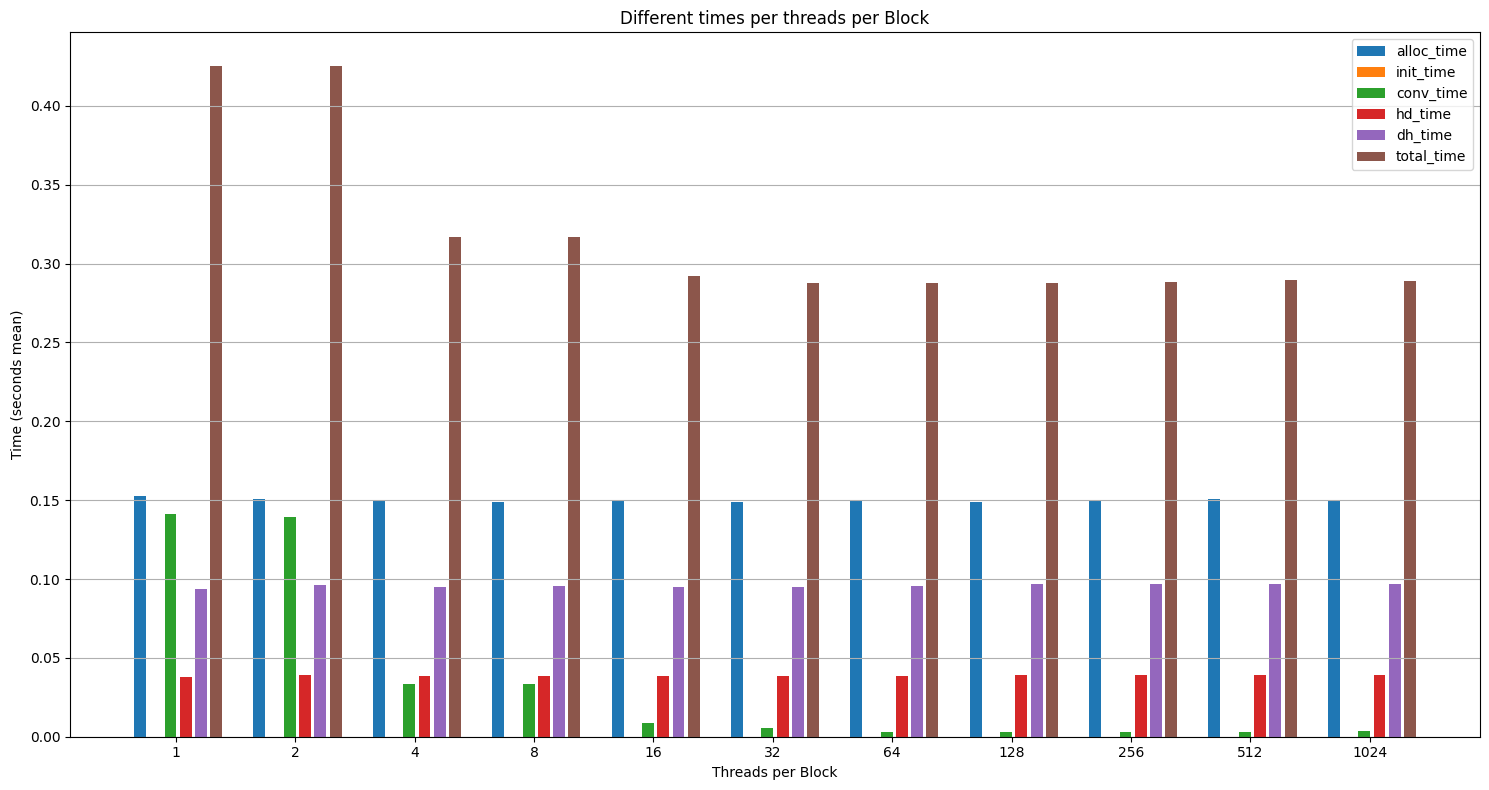

In [9]:
# Bar plot with all diferent times per threadsPerBlock unique values
# -----------------------------------------------------------------

data_filtered = data[data['imagePath'] == fixed_image]

unique_threadsPerBlock = data_filtered['threadsPerBlock'].unique()
n_groups = len(unique_threadsPerBlock)
metrics = ['alloc_time', 'init_time', 'conv_time', 'hd_time', 'dh_time', 'total_time']
n_metrics = len(metrics)
bar_width = 0.1
index = np.arange(n_groups)

plt.figure(figsize=(15, 8))

for j, metric in enumerate(metrics):

	means = [data_filtered[data_filtered['threadsPerBlock'] == tp][metric].mean() for tp in unique_threadsPerBlock]
	plt.bar(index + j * bar_width * 1.275, means, bar_width, label=metric)

plt.xlabel('Threads per Block')
plt.ylabel('Time (seconds mean)')

plt.xticks(index + bar_width * (n_metrics / 2), unique_threadsPerBlock)

plt.title('Different times per threads per Block')
plt.legend()
plt.grid(axis='y')
plt.tight_layout()

plt.savefig(os.path.join(images_dir, 'times_per_threadsPerBlock.png'))

plt.show()

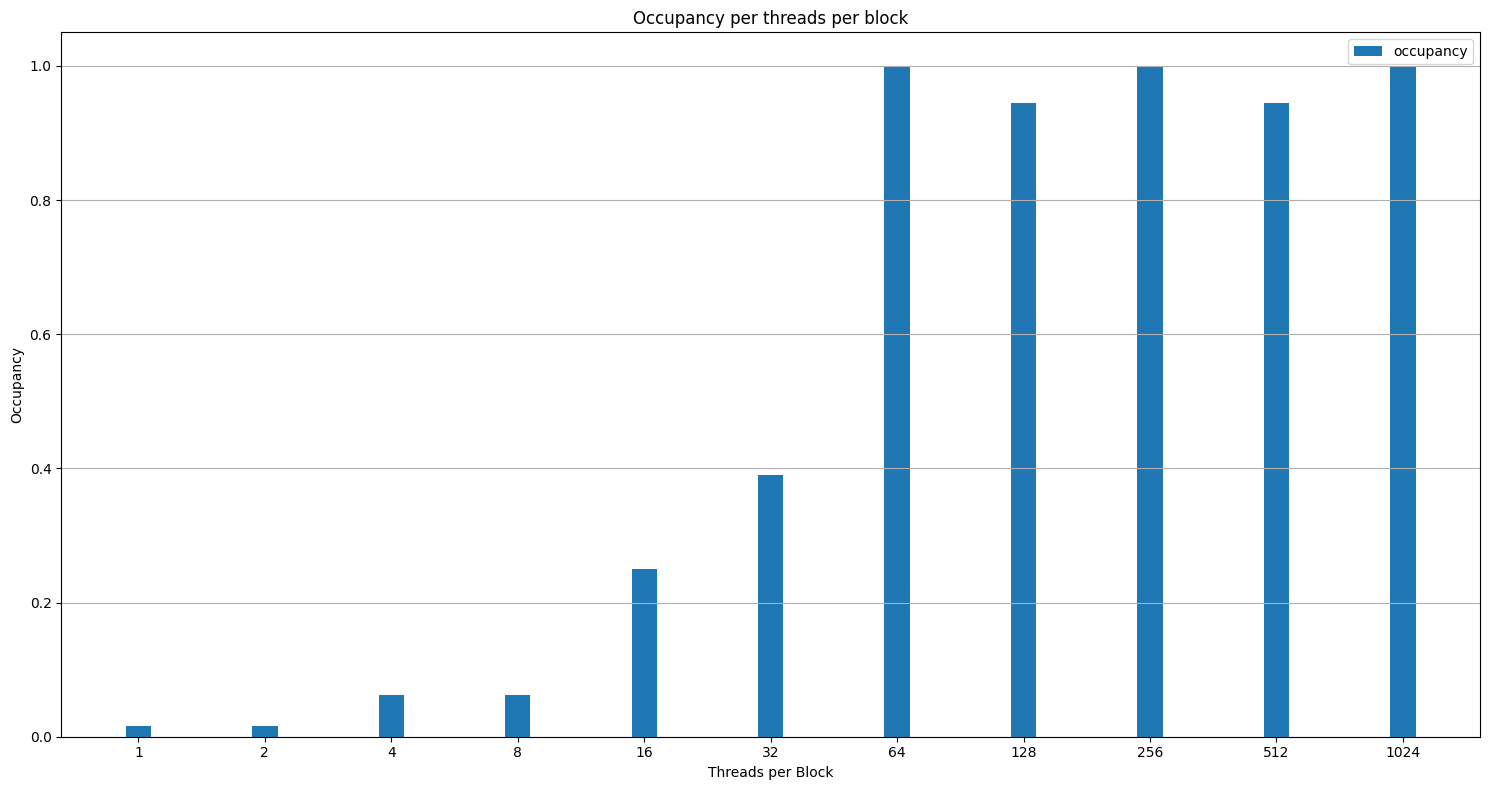

In [10]:

data_filtered = data[data['imagePath'] == fixed_image]

unique_threadsPerBlock = data_filtered['threadsPerBlock'].unique()
n_groups = len(unique_threadsPerBlock)
metrics = ['occupancy']
n_metrics = len(metrics)

bar_width = 0.2
index = np.arange(n_groups)

plt.figure(figsize=(15, 8))

for j, metric in enumerate(metrics):

	means = [data_filtered[data_filtered['threadsPerBlock'] == tp][metric].mean() for tp in unique_threadsPerBlock]
	plt.bar(index + j * bar_width, means, bar_width, label=metric)

plt.xlabel('Threads per Block')
plt.ylabel('Occupancy')
plt.xticks(index, unique_threadsPerBlock)

plt.title('Occupancy per threads per block')
plt.legend()
plt.grid(axis='y')
plt.tight_layout()

plt.savefig(os.path.join(images_dir, 'occupancy_per_threadsPerBlock.png'))

plt.show()

In [11]:
finalData = []

data_filtered = data

min_process = data_filtered['threadsPerBlock'].min()

ref_dataset = data_filtered[data_filtered['threadsPerBlock'] == min_process]

ref_times = ref_dataset.groupby('imagePath')['conv_time'].max()

for (image_value, threads_value), group in data_filtered.groupby(['imagePath', 'threadsPerBlock']):

	max_compute_time = group['conv_time'].max()
	max_total_time = group['total_time'].max()

	ref_time = ref_times.get(image_value, None)

	speedup = ref_time / max_compute_time
	efficiency = speedup / threads_value

	# Secuential daxpy time 0.8514 seconds and total time 4.3128s
	# Histogram - 0.2045 seconds and 0.6341 seconds

	secuential_compute_speedup = 1.3064/ max_compute_time
	secuential_total_speedup =  1.6452/ max_total_time

	quality = 1 / max_compute_time

	finalData.append([threads_value, image_value, max_compute_time, ref_time, speedup, efficiency, quality, secuential_compute_speedup, secuential_total_speedup])

final_df = pd.DataFrame(finalData, columns=['threads', 'imagePath', 'MaxTime', 'RefTime', 'Speedup', 'Efficiency', 'Quality', 'SecuentialComputeSpeedup', 'SecuentialTotalSpeedup'])

display(final_df)

# Generate table latex code for the final_df DataFrame fixed to 2 decimal places
final_df.to_latex(os.path.join(images_dir, 'final_df.tex'), index=False, float_format="%.2f")

,threads,imagePath,MaxTime,RefTime,Speedup,Efficiency,Quality,SecuentialComputeSpeedup,SecuentialTotalSpeedup
0,1,./images/grayscale_by_cols.pgm,0.145968,0.145968,1.000000,1.000000,6.850802,8.949888,3.739171
1,2,./images/grayscale_by_cols.pgm,0.145970,0.145968,0.999990,0.499995,6.850732,8.949796,3.743385
2,4,./images/grayscale_by_cols.pgm,0.036741,0.145968,3.972846,0.993212,27.217181,35.556525,5.117875
3,8,./images/grayscale_by_cols.pgm,0.036743,0.145968,3.972731,0.496591,27.216396,35.555499,5.106729
4,16,./images/grayscale_by_cols.pgm,0.009673,0.145968,15.090726,0.943170,103.383576,135.060304,5.522899
5,32,./images/grayscale_by_cols.pgm,0.006254,0.145968,23.338908,0.729341,159.890234,208.880601,5.556967
6,64,./images/grayscale_by_cols.pgm,0.003476,0.145968,41.995482,0.656179,287.702728,375.854844,5.662841
7,128,./images/grayscale_by_cols.pgm,0.002919,0.145968,50.009328,0.390698,342.603996,447.577861,5.562413
8,256,./images/grayscale_by_cols.pgm,0.002995,0.145968,48.738217,0.190384,333.895866,436.201559,5.533135
9,512,./images/grayscale_by_cols.pgm,0.003204,0.145968,45.555262,0.088975,312.090069,407.714466,5.530022


/tmp/ipykernel_67235/2563868311.py:36: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  final_df.to_latex(os.path.join(images_dir, 'final_df.tex'), index=False, float_format="%.2f")


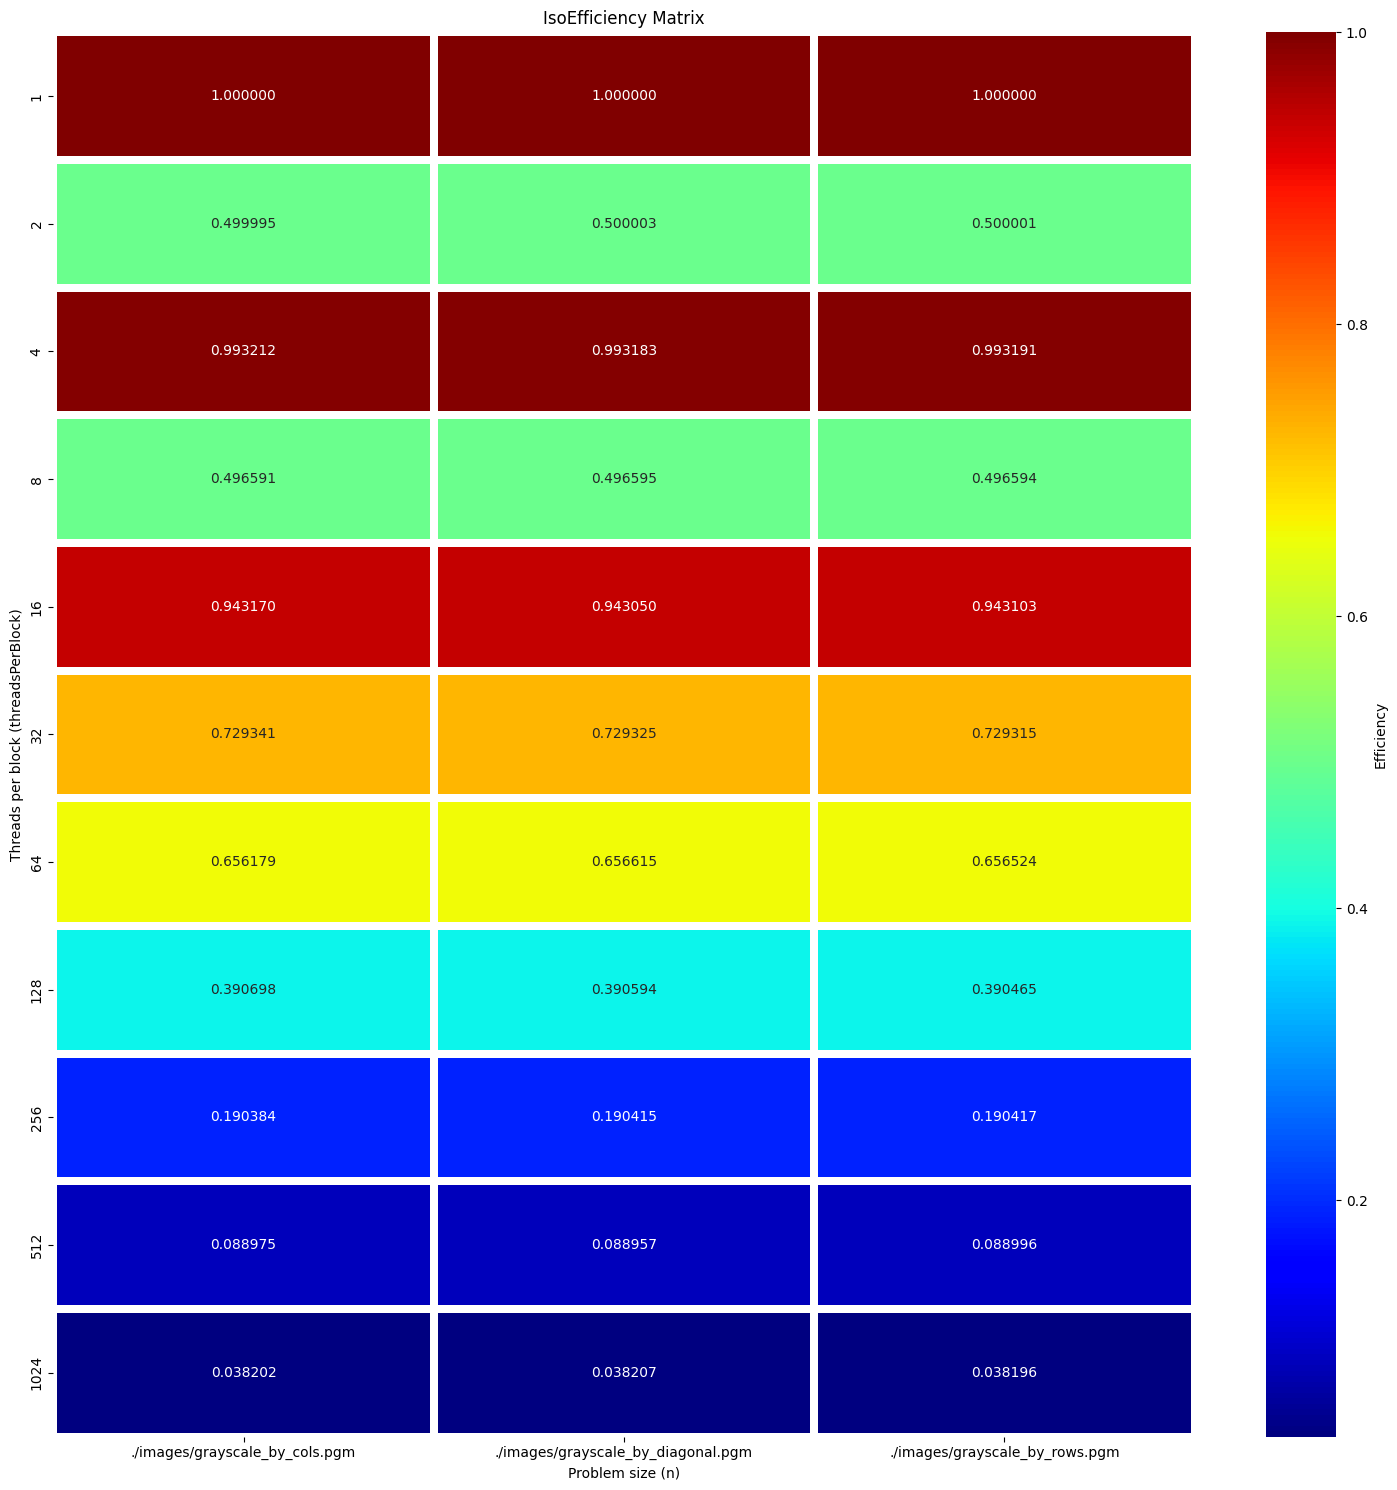

In [12]:
efficiency_matrix = final_df.pivot(index='threads', columns='imagePath', values='Efficiency')

plt.figure(figsize=(15, 15))

ax = sns.heatmap(efficiency_matrix, annot=True, fmt=".6f", cmap='jet', cbar_kws={'label': 'Efficiency'}, linewidths=4.5, linecolor='white')

ax.set_title("IsoEfficiency Matrix")
ax.set_xlabel("Problem size (n)")
ax.set_ylabel("Threads per block (threadsPerBlock)")

plt.tight_layout()

plt.savefig(os.path.join(images_dir, 'isoEfficiencyMatrix.png'))

plt.show()